TASK: [T390519](https://phabricator.wikimedia.org/T390519)

## Introduction

::: {.callout-note icon="false" appearance="simple"}

In 2024, we did the [first iteration](https://analytics.wikimedia.org/published/reports/content_translation/cx_deletion_rate_factors_report_202404.html) to understand various factors that affect the deletion rate of articles created through the Content Translation (CX) tool, which are mostly translations from a source to a target language. The analysis did reveal interesting insights, and one thing that particularly stood out was that articles that met the [Standard Quality Criteria](https://meta.wikimedia.org/wiki/Research:Knowledge_Gaps_Index/Measurement/Content#Standard_Quality_Criteria) were almost never deleted. While that is a useful insight, there was interest in understanding why. As a result, there has been a [request](https://phabricator.wikimedia.org/T389676) for follow-up analysis, to further explore these factors and investigate insights from related qualitative studies. This analysis is Part-A of the follow-up analysis, which is more exploratory to understand the distribution of translated articles (through CX) across the six standard quality criteria,^[An article is considered to meet the standard criteria if it satisfies five of the six] which are:

* It is at least 8kB long in size
* It has at least 1 category
* It has at least 7 sections
* It is illustrated with 1 or more images
* Its references are at least 4
* It has 2 or more intra wiki links

In this analysis, we will explore the state of translated articles across these criteria, and the goal is to answer questions such as:

- How many of the articles translated using CX are of standard quality?
- For articles which are not of standard quality, have there been any improvements post-creation?
- For articles that do not meet the standard quality, what are their distributions like (for example, how many of the articles meet four of the six criteria)?

In this analysis, we will only be considering articles that were not deleted at the time of data gathering (as of March 2025). These will be considered in Part B of the analysis, but for this part the assumption is that if an article is deleted after creation, then it is assumed to be of lower quality. 

:::

::: {.callout-note icon="false" appearance="simple" title="Data gathering" collapse=true}

The data sources are:

* [wmf.mediawiki_history](https://datahub.wikimedia.org/dataset/urn:li:dataset:(urn:li:dataPlatform:hive,wmf.mediawiki_history,PROD)/Schema?is_lineage_mode=false&schemaFilter=): to identify articles created using CX, along with metadata such as page information, user experience, etc.
* [canonical_data.wikis](https://datahub.wikimedia.org/dataset/urn:li:dataset:(urn:li:dataPlatform:hive,canonical_data.wikis,PROD)/Schema?is_lineage_mode=false&schemaFilter=): information about wikis that are only currently in production.
* [content_gap_metrics.metric_features](https://datahub.wikimedia.org/dataset/urn:li:dataset:(urn:li:dataPlatform:hive,content_gap_metrics.metric_features,PROD)/Schema?is_lineage_mode=false&schemaFilter=): information about whether articles meet the standard quality criteria.
* [research.article_features](https://datahub.wikimedia.org/dataset/urn:li:dataset:(urn:li:dataPlatform:hive,research.article_features,PROD)?is_lineage_mode=false): data on individual features (the six criteria) that determine whether an article meets standard quality.

For more details and the queries, please refer to the [data gathering notebook](https://gitlab.wikimedia.org/repos/lpl/analytics/translated-articles-deletion-factors/-/blob/main/2025-T389676/01_data-gathering.ipynb?ref_type=heads).

:::

## Setup 

In [233]:
import pandas as pd
import numpy as np
import duckdb

import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.io as pio
from plotly.offline import (
    download_plotlyjs, 
    init_notebook_mode,
    iplot
)

# import bambi as bmb

import great_tables as gt

In [234]:
init_notebook_mode(connected=True)

pd.options.display.max_columns = None
pd.options.display.max_rows = 250

# default dimensions for charts
iplot_width = 950
max_width = 1250

# always show options bar
iplot_config = {'displayModeBar': True}

pio.templates.default = 'simple_white'

In [235]:
#| output: false

con = duckdb.connect('secrets/T389676.duckdb', read_only=True)

print(duckdb.__version__, con)

1.2.0 <duckdb.duckdb.DuckDBPyConnection object at 0x7ceb2b36d130>


In [236]:
# con.close()

## Analysis

In [237]:
#| output: false

con.execute("""
CREATE OR REPLACE TEMP VIEW cx_init AS
SELECT 
    * 
FROM 
    translations_creation
WHERE 
    NOT is_page_deleted
    AND COLUMNS(*) IS NOT NULL
""")

In [238]:
#| output: false

con.execute("""
CREATE OR REPLACE TEMP VIEW cx_latest AS 
SELECT 
    * 
FROM 
    translations_latest
WHERE 
    COLUMNS(*) IS NOT NULL
""")

In [239]:
std_qual_init_latest_overall = con.sql("""
WITH base AS (
    SELECT
        i.wiki_db,
        i.page_id,
        CONCAT_WS('-', i.wiki_db, i.page_id) AS db_page_id,
        i.is_std_qual AS is_std_qual_init,
        l.is_std_qual AS is_std_qual_latest
    FROM
        cx_init i
    JOIN
        cx_latest l
        ON i.wiki_db = l.wiki_db
            AND i.page_id = l.page_id
),

grouped AS (
    SELECT
        CAST(is_std_qual_init AS BOOLEAN) AS is_std_qual_init,
        CAST(is_std_qual_latest AS BOOLEAN) AS is_std_qual_latest,
        COUNT(DISTINCT db_page_id) AS article_count
    FROM
        base
    GROUP BY ALL
),

total AS (
    SELECT SUM(article_count) AS total_count FROM grouped
)

SELECT
    g.*,
    g.article_count / t.total_count AS pct
FROM
    grouped g
CROSS JOIN
    total t
""").df()

### Standard quality: Overall

In [240]:
std_qual_init_latest_overall_tbl = (
    gt.GT(std_qual_init_latest_overall.sort_values(['is_std_qual_init', 'is_std_qual_latest']))
    .tab_header('Articles translated using CX - standard quality, at creation and latest')
    .fmt_percent(columns='pct')
    .cols_label({
        'is_std_qual_init': 'Standard quality, at creation',
        'is_std_qual_latest': 'Standard quality, latest',
        'article_count': '# Articles',
        'pct': 'Percentage'
    })
    .opt_stylize()
    .tab_source_note('as of March 2025')
)

std_qual_init_latest_overall_tbl

GT(_tbl_data=   is_std_qual_init  is_std_qual_latest  article_count       pct
0             False               False        1365382  0.782589
3             False                True         123156  0.070589
1              True               False          23467  0.013450
2              True                True         232694  0.133372, _body=<great_tables._gt_data.Body object at 0x7ceb1053dbb0>, _boxhead=Boxhead([ColInfo(var='is_std_qual_init', type=<ColInfoTypeEnum.default: 1>, column_label='Standard quality, at creation', column_align='center', column_width=None), ColInfo(var='is_std_qual_latest', type=<ColInfoTypeEnum.default: 1>, column_label='Standard quality, latest', column_align='center', column_width=None), ColInfo(var='article_count', type=<ColInfoTypeEnum.default: 1>, column_label='# Articles', column_align='right', column_width=None), ColInfo(var='pct', type=<ColInfoTypeEnum.default: 1>, column_label='Percentage', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7ceb0b1af0e0>, _spanners=Spanners([]), _heading=Heading(title='Articles translated using CX - standard quality, at creation and latest', subtitle=None, preheader=None), _stubhead=None, _source_notes=['as of March 2025'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7ceac2406cc0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7cea5ecef830>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#004D80'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#004D80'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo

::: {.callout-tip title="Summary" icon="false" collapse=false}

* As of March 2025, ~20% of the articles created through the Content Translation tool meet the standard quality.
    * Of these, ~13% met the standard quality at the time of creation, while 7% improved later.
* Interestingly, about 1% of articles met the standard quality at the time of creation but not at the latest snapshot. We will further explore the potential causes behind this.
* Almost 78% of articles did not meet the standard quality at either the time of creation or the latest snapshot.

:::

### Causes for quality decrease

In [241]:
n_lost_std_qual = std_qual_init_latest_overall.query("""(is_std_qual_init == True) & (is_std_qual_latest == False)""").article_count.values[0]
n_gained_std_qual = std_qual_init_latest_overall.query("""(is_std_qual_init == False) & (is_std_qual_latest == True)""").article_count.values[0]

In [242]:
stand_qual_reduction_reasons = con.sql("""
WITH base AS (
    SELECT
        i.wiki_db,
        i.page_id,
        CONCAT_WS('-', i.wiki_db, i.page_id) AS db_page_id,
        i.is_std_qual AS is_std_qual_init,
        l.is_std_qual AS is_std_qual_latest,
        i.page_length AS page_length_init,
        l.page_length AS page_length_latest,
        i.num_refs AS num_refs_init,
        l.num_refs AS num_refs_latest,
        i.num_wikilinks AS num_wikilinks_init,
        l.num_wikilinks AS num_wikilinks_latest,
        i.num_categories AS num_categories_init,
        l.num_categories AS num_categories_latest,
        i.num_media AS num_media_init,
        l.num_media AS num_media_latest,
        i.num_headings AS num_headings_init,
        l.num_headings AS num_headings_latest
    FROM
        cx_init i
    JOIN
        cx_latest l
        ON i.wiki_db = l.wiki_db
           AND i.page_id = l.page_id
    WHERE
        i.is_std_qual = 1 AND l.is_std_qual = 0
)

SELECT
    COUNT_IF(page_length_latest < page_length_init) AS reduced_length,
    COUNT_IF(num_refs_latest < num_refs_init) AS reduced_refs,
    COUNT_IF(num_wikilinks_latest < num_wikilinks_init) AS reduced_wikilinks,
    COUNT_IF(num_categories_latest < num_categories_init) AS reduced_categories,
    COUNT_IF(num_media_latest < num_media_init) AS reduced_media,
    COUNT_IF(num_headings_latest < num_headings_init) AS reduced_headings
FROM
    base
""").df().transpose().reset_index()


stand_qual_reduction_reasons = stand_qual_reduction_reasons.rename({
    'index': 'Article feature',
    0: 'Count'
}, axis=1)

In [243]:
#| column: page-right

fig = px.bar(
    stand_qual_reduction_reasons.sort_values('Count', ascending=False),
    x='Article feature',
    y='Count',
    title='Potential causes for losing standard quality of CX-created articles (at creation to latest)',
    text='Count'
)

fig.update_layout(
    title={
        'text': f'Potential causes for losing standard quality of CX-created articles (at creation to latest)<br><br>\
                    <sup>in total {n_lost_std_qual} articles lost standard quality; as of March 2025</sup>',
        'x': 0.5,
        'xanchor': 'center'
    },
    width=1000, height=400
)
fig.show()

::: {.callout-tip title="Summary" icon="false" collapse=false}

* 23K articles (~1% of the total) met the standard quality at the time of creation but not at the latest snapshot.
* Of these, the three most common potential causes are reduction in length, decrease in wikilinks, and removal of references.
* While the reduction in references and headers is also a substantial potential cause, they may be associated with content removal, which, along with reduced length, may also result in the removal of links, references, and sections.
* Note: The potential causes are exploratory based on the available data and do not imply direct causation, as there may be other contributing factors.

:::

### Causes for quality increase

In [244]:
std_qual_user_experience = con.sql("""
WITH improved AS (
    SELECT
        i.wiki_db,
        i.page_id,
        i.user_edit_count,
        i.user_article_count,
        i.user_cx_article_count,
        CONCAT_WS('-', i.wiki_db, i.page_id) AS db_page_id,
        CASE 
            WHEN (i.is_std_qual = 0 AND l.is_std_qual = 1) THEN 'increased'
            WHEN (i.is_std_qual = 0 AND l.is_std_qual = 0) THEN 'no change'
            WHEN (i.is_std_qual = 1 AND l.is_std_qual = 0) THEN 'decreased'
        END AS quality_change
    FROM
        cx_init i
    JOIN
        cx_latest l
        ON i.wiki_db = l.wiki_db
           AND i.page_id = l.page_id
    WHERE
        NOT (i.is_std_qual = 1 AND l.is_std_qual = 1)
)

SELECT 
    * 
FROM 
    improved
""").df()

In [245]:
stand_qual_growth_reasons = con.sql("""
WITH base AS (
    SELECT
        i.wiki_db,
        i.page_id,
        CONCAT_WS('-', i.wiki_db, i.page_id) AS db_page_id,
        i.is_std_qual AS is_std_qual_init,
        l.is_std_qual AS is_std_qual_latest,
        i.page_length AS page_length_init,
        l.page_length AS page_length_latest,
        i.num_refs AS num_refs_init,
        l.num_refs AS num_refs_latest,
        i.num_wikilinks AS num_wikilinks_init,
        l.num_wikilinks AS num_wikilinks_latest,
        i.num_categories AS num_categories_init,
        l.num_categories AS num_categories_latest,
        i.num_media AS num_media_init,
        l.num_media AS num_media_latest,
        i.num_headings AS num_headings_init,
        l.num_headings AS num_headings_latest
    FROM
        cx_init i
    JOIN
        cx_latest l
        ON i.wiki_db = l.wiki_db
           AND i.page_id = l.page_id
    WHERE
        i.is_std_qual = 0 AND l.is_std_qual = 1
)

SELECT
    COUNT_IF(page_length_latest > page_length_init) AS increased_length,
    COUNT_IF(num_refs_latest > num_refs_init) AS increased_refs,
    COUNT_IF(num_wikilinks_latest > num_wikilinks_init) AS increased_wikilinks,
    COUNT_IF(num_categories_latest > num_categories_init) AS increased_categories,
    COUNT_IF(num_media_latest > num_media_init) AS increased_media,
    COUNT_IF(num_headings_latest > num_headings_init) AS increased_headings
FROM
    base
""").df().transpose().reset_index()


stand_qual_growth_reasons = stand_qual_growth_reasons.rename({
    'index': 'Article feature',
    0: 'Count'
}, axis=1)

In [246]:
#| column: page-right

fig = px.bar(
    stand_qual_growth_reasons.sort_values('Count', ascending=False),
    x='Article feature',
    y='Count',
    text='Count'
)

fig.update_layout(
    title={
        'text': f'Potential causes for gaining standard quality of CX-created articles (at creation to latest)<br><br>\
                    <sup>in total {n_gained_std_qual} articles lost standard quality; as March 2025</sup>',
        'x': 0.5,
        'xanchor': 'center'
    },
    width=1000, height=400
)
fig.show()


::: {.callout-tip title="Summary" icon="false"}

* 120K articles (~7% of the total) did not meet the standard quality at the time of creation but were later improved and, as of March 2025, meet the standard. 
* Of these, the three most common potential causes are increase in article length, addition of wikilinks, and increased headings (sections).
* In nearly 60% of the articles that were improved after creation, the addition of media (at least one image) contributed to meeting the standard quality.
* Note: These potential causes are exploratory and based on available data. They do not imply direct causation, as other factors may also be involved.

:::

### Distribution by criteria met

In [247]:
cx_latest = con.sql("""SELECT * FROM cx_latest""").df()

In [248]:
cx_latest = cx_latest.assign(
    thres_length=(cx_latest['page_length'] >= 8000).astype(int),
    thres_categories=(cx_latest['num_categories'] >= 1).astype(int),
    thres_headings=(cx_latest['num_headings'] >= 7).astype(int),
    thres_media=(cx_latest['num_media'] >= 1).astype(int),
    thres_refs=(cx_latest['num_refs'] >= 4).astype(int),
    thres_wikilinks=(cx_latest['num_wikilinks'] >= 2).astype(int)
).assign(
    criteria_met=lambda df: (
        df['thres_length'] +
        df['thres_categories'] +
        df['thres_headings'] +
        df['thres_media'] +
        df['thres_refs'] +
        df['thres_wikilinks']
    )
)

criteria_distribution = cx_latest['criteria_met'].value_counts().sort_index(ascending=False).reset_index()

In [249]:
#| column: page

total = criteria_distribution.query("criteria_met < 5")['count'].sum()
criteria_distribution['percentage'] = criteria_distribution['count'] / total

greens = px.colors.sequential.Greens[-5:] 

sorted_subset = (
    criteria_distribution[criteria_distribution['criteria_met'] < 5]
    .sort_values('percentage')
)

color_map = {
    int(row.criteria_met): color
    for row, color in zip(sorted_subset.itertuples(), greens)
}

bars = []
annotations = []

for row in criteria_distribution.itertuples():
    criteria = int(row.criteria_met)
    color = color_map.get(criteria, 'lightgrey')
    
    text = f"{row.percentage:.2%}" if criteria < 5 else None
    show_text = text if criteria < 5 else None
    
    bars.append(go.Bar(
        x=[str(criteria)],
        y=[row.count],
        marker_color=color,
        text=[show_text] if show_text else None,
        textposition='inside' if show_text else None
    ))
    
    if criteria >= 5:
        annotations.append(dict(
            x=str(criteria),
            y=row.count / 2,
            text=f'meets std quality',
            showarrow=False,
            font=dict(color='black', size=13)
        ))

fig = go.Figure(bars)

fig.update_layout(
    title='Distribution of articles created using CX by number of standard quality criteria met<br><sup>as of March 2025</sup>',
    xaxis_title='Standard quality criteria met (of six)',
    yaxis_title='Article count',
    xaxis=dict(categoryorder='array', categoryarray=[str(i) for i in range(7)]),
    showlegend=False,
    annotations=annotations,
    width=1100, height=400
)

fig.show()

::: {.callout-tip title="Summary" icon="false"}

* Among the articles that did not meet the standard quality, the largest group (40%) met three of the six criteria -- just two short of the threshold.
* The next most frequent were articles that met two of the six criteria (30%) and those that met four (23%).
* A very small percentage of articles (<5%) met only one or none of the criteria.

:::

### Shortfall from standard quality

In [250]:
def format_big_number(n):
    if n >= 1000000:
        return f'{n/1000000:.1f}M'
    elif n >= 1000:
        return f'{n/1000:.1f}K'
    else:
        return str(int(n))

In [251]:
threshold_values = {
    'page_length': 8000,
    'num_categories': 1,
    'num_headings': 7,
    'num_media': 1,
    'num_refs': 4,
    'num_wikilinks': 2
}

threshold_flags = {
    'page_length': 'thres_length',
    'num_categories': 'thres_categories',
    'num_headings': 'thres_headings',
    'num_media': 'thres_media',
    'num_refs': 'thres_refs',
    'num_wikilinks': 'thres_wikilinks',
}

quality_subset = cx_latest[cx_latest['criteria_met'].isin([1, 2, 3, 4])].copy()

for feature, threshold in threshold_values.items():
    shortfall_column = f'shortfall_{feature}'
    flag_column = threshold_flags[feature]
    quality_subset[shortfall_column] = np.where(
        quality_subset[flag_column] == 0,
        threshold - quality_subset[feature],
        0
    )

shortfall_columns = [f'shortfall_{feature}' for feature in threshold_values]
melted_shortfalls = quality_subset.melt(
    id_vars='criteria_met',
    value_vars=shortfall_columns,
    var_name='criterion',
    value_name='shortfall'
)
melted_shortfalls['criterion'] = melted_shortfalls['criterion'].str.replace('shortfall_', '')

avg_shortfalls = (
    melted_shortfalls[melted_shortfalls['shortfall'] > 0]
    .groupby(['criteria_met', 'criterion'])['shortfall']
    .agg(avg_shortfall='mean')
    .reset_index()
)

miss_counts = []

for level in range(1, 5):
    level_df = quality_subset[quality_subset['criteria_met'] == level]
    for feature, flag_col in threshold_flags.items():
        count_missed = (level_df[flag_col] == 0).sum()
        miss_counts.append({
            'criteria_met': level,
            'criterion': feature,
            'miss_count': count_missed
        })

miss_counts_df = pd.DataFrame(miss_counts)

combined_shortfall_df = pd.merge(
    avg_shortfalls,
    miss_counts_df,
    on=['criteria_met', 'criterion'],
    how='left'
)

combined_shortfall_df['criteria_met_label'] = combined_shortfall_df['criteria_met'].astype(str) + ' of 6 criteria met'
combined_shortfall_df['criterion'] = combined_shortfall_df['criterion'].replace({
    'page_length': 'page_length (in bytes)'
})

combined_shortfall_df = combined_shortfall_df.sort_values(['criteria_met', 'miss_count'], ascending=[True, False]).reset_index(drop=True)
combined_shortfall_df['miss_count_fmt'] = combined_shortfall_df['miss_count'].apply(format_big_number)

In [252]:
agg_shortfall_tbl = (
    gt.GT(combined_shortfall_df, groupname_col='criteria_met_label', rowname_col='criterion')
    .tab_header('Aggregate shortfall from standard quality', 'of articles created using CX')
    .cols_hide(['criteria_met', 'miss_count'])
    .fmt_number(columns='avg_shortfall', decimals=0)
    .cols_move_to_start('miss_count_fmt')
    .cols_align(align='right', columns='miss_count_fmt')
    .cols_align(align='left', columns='avg_shortfall')
    .tab_style(
        style=gt.style.borders(sides='right', style='solid'),
        locations=gt.loc.body(columns='miss_count_fmt')
    )
    .cols_label(
        avg_shortfall='Average shortfall',
        miss_count_fmt='Count of shortfall articles'
    )
    .opt_stylize()
    .opt_table_outline()
    .tab_source_note('as of March 2025')
)

agg_shortfall_tbl

GT(_tbl_data=    criteria_met               criterion  avg_shortfall  miss_count  \
0              1  page_length (in bytes)    6576.302601       68212   
1              1            num_headings       5.346906       67955   
2              1                num_refs       3.097085       65458   
3              1               num_media       1.001338       63507   
4              1          num_categories       1.002143       39660   
5              1           num_wikilinks       1.447129       36873   
6              2  page_length (in bytes)    5763.087100      416740   
7              2            num_headings       4.496404      415198   
8              2                num_refs       2.700322      397059   
9              2               num_media       1.000000      381765   
10             2          num_categories       1.000000       37712   
11             2           num_wikilinks       1.389222       20338   
12             3  page_length (in bytes)    4447.810120      555018   
13             3            num_headings       3.922965      542067   
14             3                num_refs       2.678601      304537   
15             3               num_media       1.000000      266781   
16             3          num_categories       1.000000       17613   
17             3           num_wikilinks       1.413557        4529   
18             4            num_headings       3.205352      269606   
19             4  page_length (in bytes)    3029.593570      264304   
20             4               num_media       1.000000       80115   
21             4                num_refs       2.623147       43643   
22             4          num_categories       1.000000        7612   
23             4           num_wikilinks       1.480952        1050   

     criteria_met_label miss_count_fmt  
0   1 of 6 criteria met          68.2K  
1   1 of 6 criteria met          68.0K  
2   1 of 6 criteria met          65.5K  
3   1 of 6 criteria met          63.5K  
4   1 of 6 criteria met          39.7K  
5   1 of 6 criteria met          36.9K  
6   2 of 6 criteria met         416.7K  
7   2 of 6 criteria met         415.2K  
8   2 of 6 criteria met         397.1K  
9   2 of 6 criteria met         381.8K  
10  2 of 6 criteria met          37.7K  
11  2 of 6 criteria met          20.3K  
12  3 of 6 criteria met         555.0K  
13  3 of 6 criteria met         542.1K  
14  3 of 6 criteria met         304.5K  
15  3 of 6 criteria met         266.8K  
16  3 of 6 criteria met          17.6K  
17  3 of 6 criteria met           4.5K  
18  4 of 6 criteria met         269.6K  
19  4 of 6 criteria met         264.3K  
20  4 of 6 criteria met          80.1K  
21  4 of 6 criteria met          43.6K  
22  4 of 6 criteria met           7.6K  
23  4 of 6 criteria met           1.1K  , _body=<great_tables._gt_data.Body object at 0x7ceb0ad73380>, _boxhead=Boxhead([ColInfo(var='miss_count_fmt', type=<ColInfoTypeEnum.default: 1>, column_label='Count of shortfall articles', column_align='right', column_width=None), ColInfo(var='criteria_met', type=<ColInfoTypeEnum.hidden: 4>, column_label='criteria_met', column_align='right', column_width=None), ColInfo(var='criterion', type=<ColInfoTypeEnum.stub: 2>, column_label='criterion', column_align='left', column_width=None), ColInfo(var='avg_shortfall', type=<ColInfoTypeEnum.default: 1>, column_label='Average shortfall', column_align='left', column_width=None), ColInfo(var='miss_count', type=<ColInfoTypeEnum.hidden: 4>, column_label='miss_count', column_align='right', column_width=None), ColInfo(var='criteria_met_label', type=<ColInfoTypeEnum.row_group: 3>, column_label='criteria_met_label', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7cea7c61e750>, _spanners=Spanners([]), _heading=Heading(title='Aggregate shortfall from standard quality', subtitle='of articles created using CX', preheader=None), _stubhead=None, _source_notes=['as of March 2025'], _footnotes=[], _st

::: {.callout-note title="Interpretation" icon="false" collapse=false}

Beyond identifying the most commonly missed standard criteria, this information can also be helpful to identify areas with the highest potential for impact, and for opportunities to improve article quality. For example, around 80K translated articles fall short of standard quality solely due to the absence of at least one media file — adding just one image could enable them to meet standard quality. Similarly, increasing the page length by approximately 3,000 bytes for articles that currently meet 4 of the 6 criteria could move about 264K articles to standard quality. For articles that meet 3 of the 6 criteria, improving any two additional features would enable them to reach standard quality.

:::

::: {.callout-tip title="Summary" icon="false" collapse=false}

* Among articles that do not meet standard quality, the most common shortfall is page length (in bytes)
* This is followed by the number of headings (i.e., sections the content is divided into) and the number of references.
    * The number of headings is likely related to page length—as content increases, the number of sections tends to increase as well.
* Across all criteria, especially in articles closer to standard quality -- the number of categories and wikilinks are the least commonly missing aspects.
* The average shortfall in page length varies significantly across article groups, more so than other criteria. We will explore this further.
  
:::

#### Page length distributions

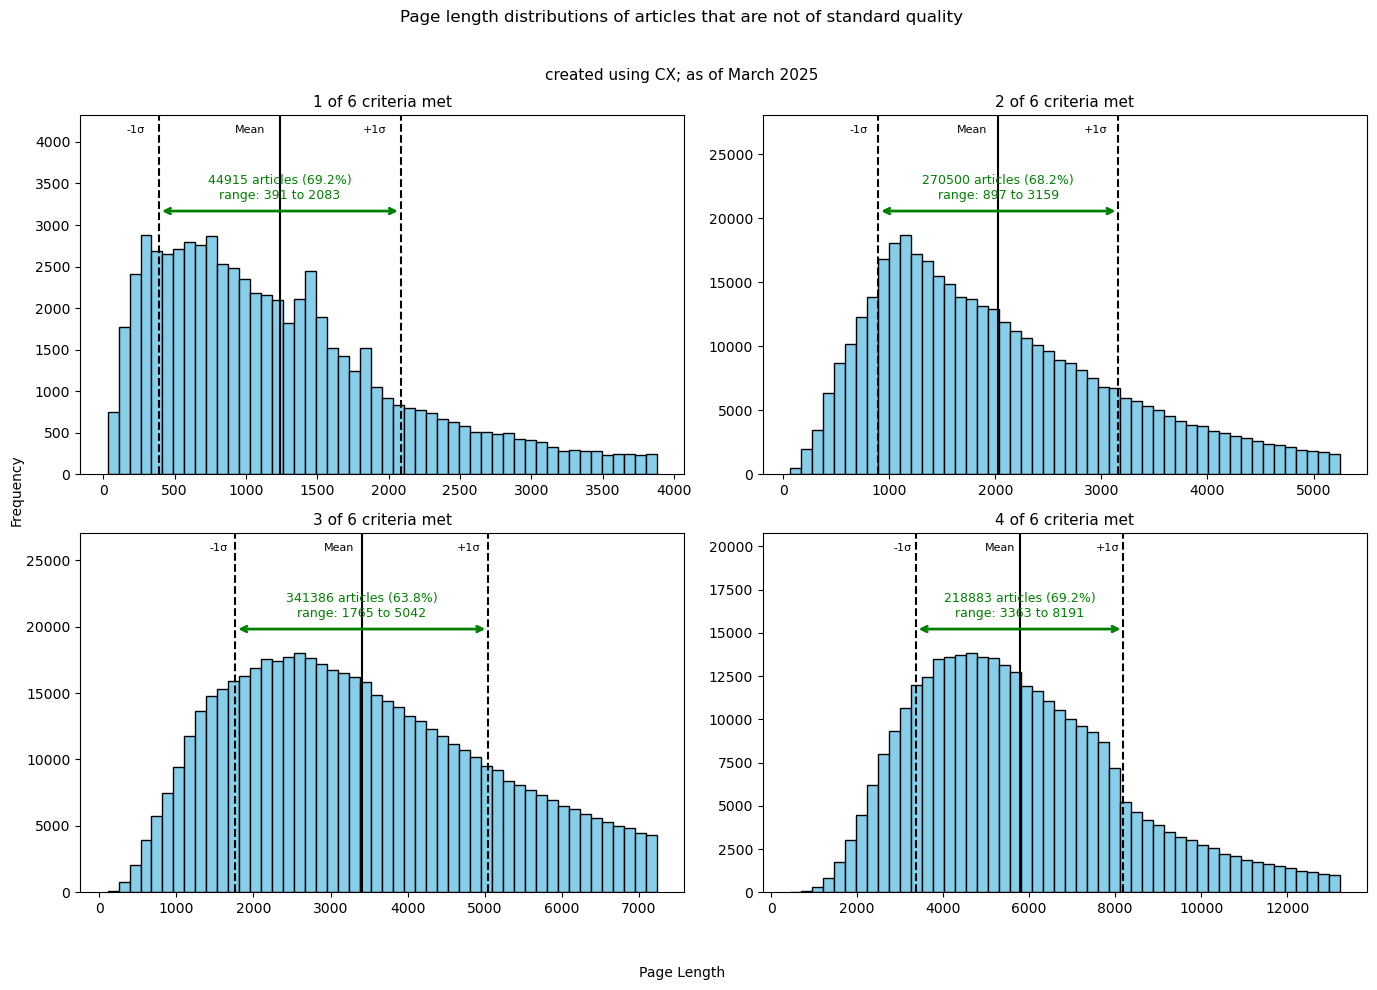

In [253]:
#| column: page

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
criteria_levels = [1, 2, 3, 4]

for idx, level in enumerate(criteria_levels):
    df_level = subset.query(f"criteria_met == {level}")
    page_lengths = df_level.page_length.values
    cutoff = np.percentile(page_lengths, 95)
    filtered_lengths = df_level.query("""page_length <= @cutoff""").page_length.values

    mean = filtered_lengths.mean()
    std = filtered_lengths.std()
    lower, upper = mean - std, mean + std
    count_within_range = ((filtered_lengths >= lower) & (filtered_lengths <= upper)).sum()
    percent_within_range = round(100 * count_within_range / len(filtered_lengths), 1)

    ax = axes[idx]
    counts, bins, _ = ax.hist(filtered_lengths, bins=50, color='skyblue', edgecolor='black')

    ax.set_ylim(0, max(counts) * 1.5)
    ax.set_title(f'{level} of 6 criteria met', fontsize=11)

    for i in [-1, 0, 1]:
        x = mean + i * std
        style = '-' if i == 0 else '--'
        label = 'Mean' if i == 0 else f'{i:+}σ'
        ax.axvline(x, color='black', linestyle=style, linewidth=1.5)
        ax.annotate(label, xy=(x-100, 0.95), xycoords=('data', 'axes fraction'),
                    ha='right', fontsize=8)

    y_arrow = max(counts) * 1.1
    ax.annotate('', xy=(lower, y_arrow), xytext=(upper, y_arrow),
                arrowprops=dict(arrowstyle='<->', color='green', linewidth=2))

    ax.text(mean, y_arrow + max(counts) * 0.05,
            f'{count_within_range} articles ({percent_within_range}%)\nrange: {int(lower)} to {int(upper)}',
            ha='center', color='green', fontsize=9)

fig.suptitle('Page length distributions of articles that are not of standard quality', fontsize=12)
fig.text(0.5, 0.91, 'created using CX; as of March 2025', fontsize=11, ha='center')
fig.supxlabel('Page Length', fontsize=10)
fig.supylabel('Frequency', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.show()

::: {.callout-tip title="Summary" icon="false" collapse=false}

* Page length (in bytes) is the criterion that varied the most across articles that did not meet standard quality, as evident from the above distributions.
* Most articles that meet only 1 of the 6 criteria are between 400 and 2,000 bytes in length.
* As articles meet more of the criteria—indicating a potential increase in quality—their average and distribution of page length move closer to the 8,000-byte threshold.
* For articles meeting 4 of the 6 criteria, approximately 69% are between 3,300 and 8,000 bytes, with about 35% falling between 5,700 and 8,000 bytes.
    * This suggests that, if these articles are expanded by 100 to 2,300 bytes, approximately 109K could meet the standard quality.
* For articles meeting 3 of the 6 criteria, around 63% are between 1,700 and 5,000 bytes, and about 31% fall between 3,400 and 5,000 bytes.
  * If these articles can be expanded by 3,000 to 4,500 bytes, along with improvements in other criteria (such as headings, as noted earlier), approximately 170K could reach standard quality.
  
:::

### Distribution by wiki

In [254]:
criteria_by_db = (
    cx_latest
    .assign(criteria_met=cx_latest['criteria_met'].astype(str).replace({'5': 'std qual', '6': 'std qual'}))
    .groupby(['wiki_db', 'criteria_met'])['page_id'].count().reset_index(name='count')
)

criteria_by_db['total'] = criteria_by_db.groupby('wiki_db')['count'].transform('sum')
criteria_by_db['percentage'] = criteria_by_db['count'] / criteria_by_db['total']

criteria_by_db.query("total >= 50").to_csv('secrets/criteria_by_db_min50_cx_032025.tsv', sep='\t', index=False)

::: {.callout-note title="Explore by wiki" icon="false"}

Distribution of articles across standard quality criteria by each wiki, can be explored in this [Google Spreadsheet](https://docs.google.com/spreadsheets/d/1_sruNNmyvLOS4gdvkCOryqqU6ezpX7ExSMiXKjgLOZk/edit?gid=1734321599#gid=1734321599&fvid=1671074555).

:::

In [ ]:
con.close()

## Summary

::: {.callout-tip icon="false" appearance=simple}

The analysis explores quality of Wikipedia articles created using the Content Translation (CX) tool and not deleted,^[approximately 1.75 million articles] focusing on how these articles align with six standard quality criteria: length (minimum 8kB), number of categories, number of sections, presence of images, number of references, and intra-wiki links. As of March 2025, about 20% of all translated articles are of standard quality. Of those, 13% met the standard at the time of creation, while another 7% were improved post-creation. About 78% of the translated articles, do not meet the standard quality. Interestingly, about 1% of articles that initially met the standard quality, later did not, possibly due to content removal. 

Among the small percentage of article that saw a drop in quality, reduction in length, decrease in wikilinks, and removal references were the most common causes. The most commons reasons for improvement in article quality are, growth in length, additional sections, and more wikilinks. In nearly 60% of the articles that were improved after creation, the addition of media (at least one image) contributed to meeting the standard quality.

Among articles that do not meet the standard quality, about 23% meet four of the six criteria, 40% meet three, and 30% meet two. This suggests that many articles are within reach of meeting the standard quality with a few targeted improvements. For instance, nearly 80,000 articles fail to qualify solely because they lack an image. Similarly, expanding articles that already meet four of six criteria by just 100 to 2,300 bytes could bring roughly 109,000 articles up to the standard quality. For articles that meet three criteria, expanding them by 3,000 to 4,500 bytes -- especially combined with addition of references or structural improvements (such as division of sections), will bring 170,000 more to standard quality.

Among all criteria, page length was the most frequently missing and highly varied. Articles that meet only one of the six criteria tend to be short, often under 2,000 bytes, while those that meet more of the criteria trend toward the 8,000-byte threshold. A lot of the articles that meet four out of six criteria are already quite close to the 8,000-byte threshold, with many of them between 5,700 and 8,000 bytes. So just expanding the articles by a few hundred to a couple of thousand bytes will enable them to meet the standard quality. The same goes for articles that meet three crteria—most are between 1,700 and 5,000 bytes, and plenty are already over 3,000 bytes.

----

While a majority of the articles still fall short of the standard quality, these insights can be helpful to identify opportunities for improving the existing articles and enabling them to meet the standard quality. 

:::
